In [1]:
import os
import pickle
import pandas as pd
import json
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

from eval import get_metric_dataframes, get_prediction_and_ground_truths, eval_single_system
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from models.diffusion import *

plt.rc('font', family='Helvetica')

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
syn_cols = dataset.ratio_names+dataset.cond_names

In [3]:
model_outputs = {}
for model_type, fname, split in [
                                # ('random', ['v0'], 'system'),
                                ('amd', 'v0', 'system'),
                                # ('nn', ['v0'], 'system'),
                                ('bnn', 'v0', 'system'),
                                ('gmm', 'v0', 'system'),
                                ('gan', 'v3', 'system'),
                                ('nf', 'v0', 'system'),
                                ('cvae', 'v10', 'system'),
                                ('diff', 'v3', 'system'),
                                ]:
    with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
        configs = json.load(f)

    if model_type == 'diff':
        syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, _ = get_prediction_and_ground_truths(_, configs, cond_scale=0.75)
    else:
        syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, _ = get_prediction_and_ground_truths(_, configs)

    model_outputs[model_type] = {'syn_pred': syn_pred, 'syn_pred_scaled': syn_pred_scaled, 'syn_true': syn_true, 'syn_true_scaled': syn_true_scaled}
    


Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...
Getting model predictions and grouth truths...
SYSTEMS:
train+val

In [4]:
def compare_side_by_side(syn_pred_list, syn_pred_scaled_list, syn_true, syn_true_scaled, dataset, zeo, osda=None, plot_kde=None, plot_bar=None,labels=None, plot=True, print_metrics=True, pca=False, xlims={}, colors=None):
    
    if osda == None: # Zeolite-aggregated
        if plot:
            print(zeo)

        sys_syn_true = syn_true[syn_true['zeo'] == zeo]
        sys_syn_true_scaled = syn_true_scaled[syn_true_scaled['zeo'] == zeo]
        sys_syn_pred_list = [x[x['zeo'] == zeo] for x in syn_pred_list]
        sys_syn_pred_scaled_list = [x[x['zeo'] == zeo] for x in syn_pred_scaled_list]
    
    else:
        if plot:
            print(zeo, osda)
        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        sys_syn_true_scaled = syn_true_scaled[(syn_true_scaled['zeo'] == zeo) & (syn_true_scaled['osda'] == osda)]
        sys_syn_pred_list = [x[(x['zeo'] == zeo) & (x['osda'] == osda)] for x in syn_pred_list]
        sys_syn_pred_scaled_list = [x[(x['zeo'] == zeo) & (x['osda'] == osda)] for x in syn_pred_scaled_list]

    if plot_kde == None:
        plot_kde = len(sys_syn_pred_list)*[False]+[False]
    if plot_bar == None:
        plot_bar = len(sys_syn_pred_list)*[True]+[True]
        
    if plot:
        utils.compare_gel_conds(sys_syn_pred_list+[sys_syn_true], labels, plot_kde=plot_kde, plot_bar=plot_bar, common_norm=True, alpha=0.35, xlims=xlims, colors=colors)
    
    # if pca:
    #     combined_df = pd.concat([sys_syn_pred1, sys_syn_pred2, sys_syn_true])
    #     combined_df['origin'] = ['diff']*len(sys_syn_pred1) + ['cvae']*len(sys_syn_pred2) + ['True']*len(sys_syn_true)
    #     X = combined_df[dataset.ratio_names+dataset.cond_names].values
    #     scaler = StandardScaler()
    #     X = scaler.fit_transform(X)
    #     pca = PCA(n_components=2)
    #     X_pca = pca.fit_transform(X)
    #     X_pca = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'origin': combined_df['origin']})
        
    #     sys_syn_pred_pca1 = X_pca[X_pca['origin'] == 'diff']
    #     sys_syn_pred_pca2 = X_pca[X_pca['origin'] == 'cvae']
    #     sys_syn_true_pca = X_pca[X_pca['origin'] == 'True']

    #     fig = plt.figure(figsize=(12, 6))

    #     ax1 = fig.add_subplot(1, 2, 1)
    #     ax1.scatter(sys_syn_true_pca['PC1'], sys_syn_true_pca['PC2'], label='True', color='tab:blue', alpha=1, s=100, linewidth=1, edgecolor='black')
    #     ax1.scatter(sys_syn_pred_pca1['PC1'], sys_syn_pred_pca1['PC2'], label='diff', color='tab:orange', alpha=0.3, linewidth=0.1, edgecolor='black')
    #     ax1.legend()
    #     ax1.set_xlim(X_pca['PC1'].min(), X_pca['PC1'].max())
    #     ax1.set_ylim(X_pca['PC2'].min(), X_pca['PC2'].max())
    
    #     ax2 = fig.add_subplot(1, 2, 2)
    #     ax2.scatter(sys_syn_true_pca['PC1'], sys_syn_true_pca['PC2'], label='True', color='tab:blue', alpha=1, s=100, linewidth=1, edgecolor='black')
    #     ax2.scatter(sys_syn_pred_pca2['PC1'], sys_syn_pred_pca2['PC2'], label='cvae', color='tab:green', alpha=0.3, linewidth=0.1, edgecolor='black')
    #     ax2.legend()
    #     ax2.set_xlim(X_pca['PC1'].min(), X_pca['PC1'].max())
    #     ax2.set_ylim(X_pca['PC2'].min(), X_pca['PC2'].max())
        
    #     plt.show()

# Zeolite-aggregated

AEL CCCNCCC


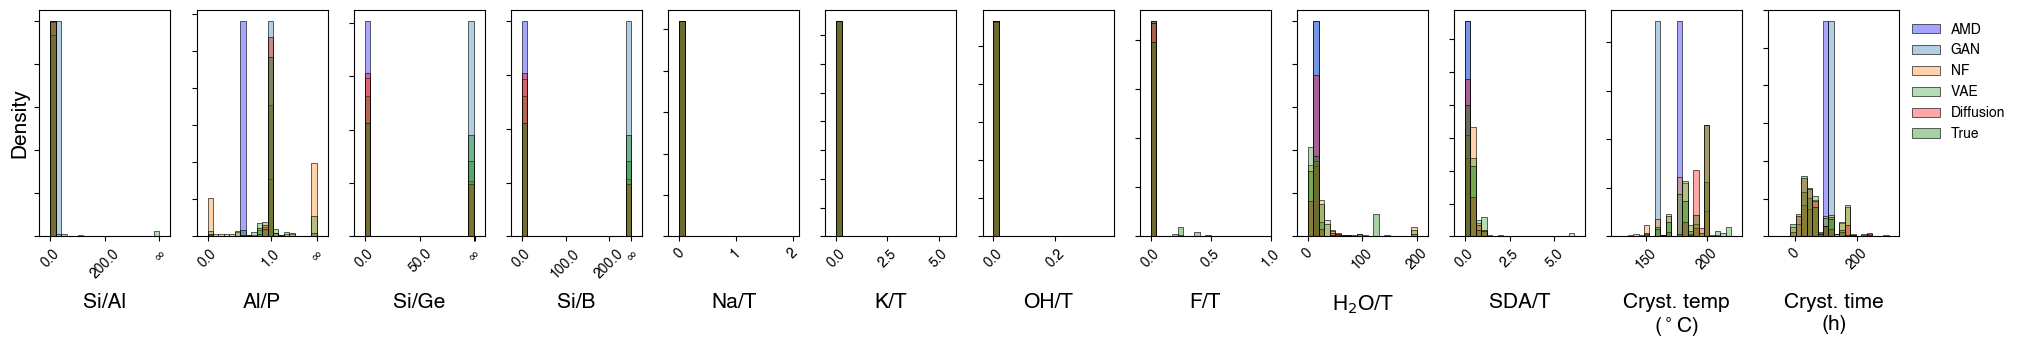

In [5]:
model2specs = {
    # 'random': {'c': 'grey', 'n': 'Random'}, 
    'amd': {'c': 'blue', 'n': 'AMD'},  
    # 'gmm': {'c': 'purple', 'n': 'GMM'}, 
    # 'bnn': {'c': 'black', 'n': 'BNN'},
    'gan': {'c': 'tab:blue', 'n': 'GAN'},
    'nf': {'c': 'tab:orange', 'n': 'NF'},
    'cvae': {'c': 'tab:green', 'n':'VAE'},
    'diff': {'c': 'red', 'n': 'Diffusion'}
}
syn_pred_list = [model_outputs[x]['syn_pred'] for x in model2specs.keys()]
syn_pred_scaled_list = [model_outputs[x]['syn_pred_scaled'] for x in model2specs.keys()]
syn_true = model_outputs['diff']['syn_true']
syn_true_scaled = model_outputs['diff']['syn_true_scaled']

compare_side_by_side(syn_pred_list, syn_pred_scaled_list, syn_true, syn_true_scaled, dataset, zeo='AEL', osda='CCCNCCC', labels=[x['n'] for x in model2specs.values()]+['True'], colors=[x['c'] for x in model2specs.values()]+['green'],
                                                                xlims={
                                                                     'cryst_temp': {'min': 130, 'max': 220}, 
                                                                     'cryst_time': {'min': -50., 'max': 300},
                                                                     },
                                                                    #  plot_kde=[False, False, True, True], plot_bar=[True, True, True, True]
                                                                     )

In [6]:
model2specs

{'amd': {'c': 'blue', 'n': 'AMD'},
 'gan': {'c': 'tab:blue', 'n': 'GAN'},
 'nf': {'c': 'tab:orange', 'n': 'NF'},
 'cvae': {'c': 'tab:green', 'n': 'VAE'},
 'diff': {'c': 'red', 'n': 'Diffusion'}}

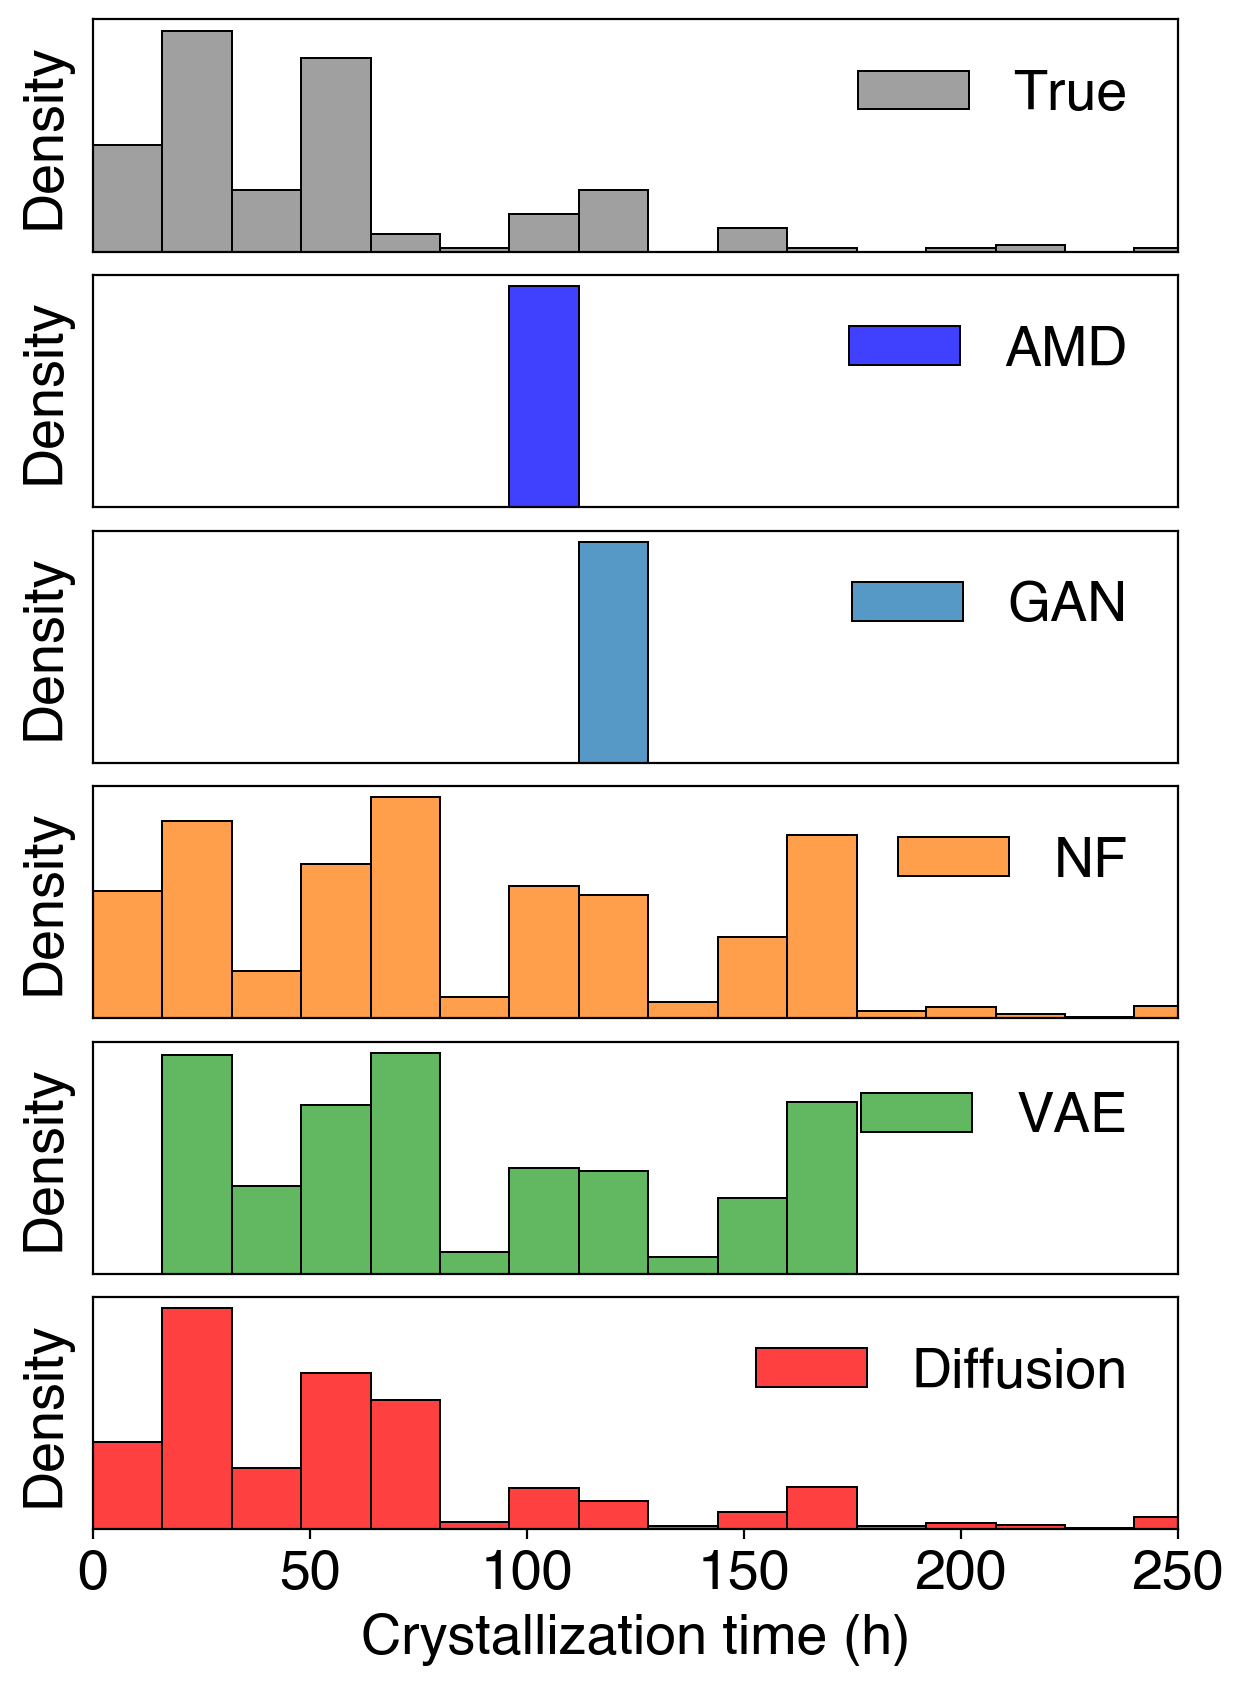

In [7]:
# Very adh-hoc plotting for NeurIPS workshop paper fig. 2d
zeo = 'AEL'
osda = 'CCCNCCC'
sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
sys_syn_true_scaled = syn_true_scaled[(syn_true_scaled['zeo'] == zeo) & (syn_true_scaled['osda'] == osda)]
sys_syn_pred_list = [x[(x['zeo'] == zeo) & (x['osda'] == osda)] for x in syn_pred_list]
sys_syn_pred_scaled_list = [x[(x['zeo'] == zeo) & (x['osda'] == osda)] for x in syn_pred_scaled_list]

labels = [x['n'] for x in model2specs.values()]

xlim = [0, 250]
fig = plt.figure(figsize=(7, 10.), dpi=200)

fig.add_subplot(len(model2specs)+1, 1, 1)
sns.histplot(sys_syn_true['cryst_time'], kde=False, color='grey', bins=50, binrange=[0, 800], label='True')
plt.xlim(*xlim)
plt.ylabel('Density', fontsize=20)
plt.xlabel('')
plt.yticks([])
plt.xticks([])
plt.xticks(fontsize=20)
plt.legend(loc='upper right', fontsize=20)
# plt.show()

for i, (sys_syn_pred, spec) in enumerate(zip(sys_syn_pred_list, model2specs.values())):

    fig.add_subplot(len(model2specs)+1, 1, i+2)
    sns.histplot(sys_syn_pred['cryst_time'], color=spec['c'], bins=50, binrange=[0, 800], label=spec['n'])

    plt.xlim(*xlim)
    plt.ylabel('Density', fontsize=20)
    if spec['n'] == 'Diffusion':
        plt.xlabel('Crystallization time (h)', fontsize=20)
    else:
        plt.xlabel('')
        plt.xticks([])
    plt.yticks([])
    plt.xticks(fontsize=20)
    plt.legend(loc='upper right', fontsize=20)
plt.subplots_adjust(hspace=0.1)
plt.savefig('figs/model_outputs_compare.pdf', dpi=200)
plt.show()


AEL CCCNCCC


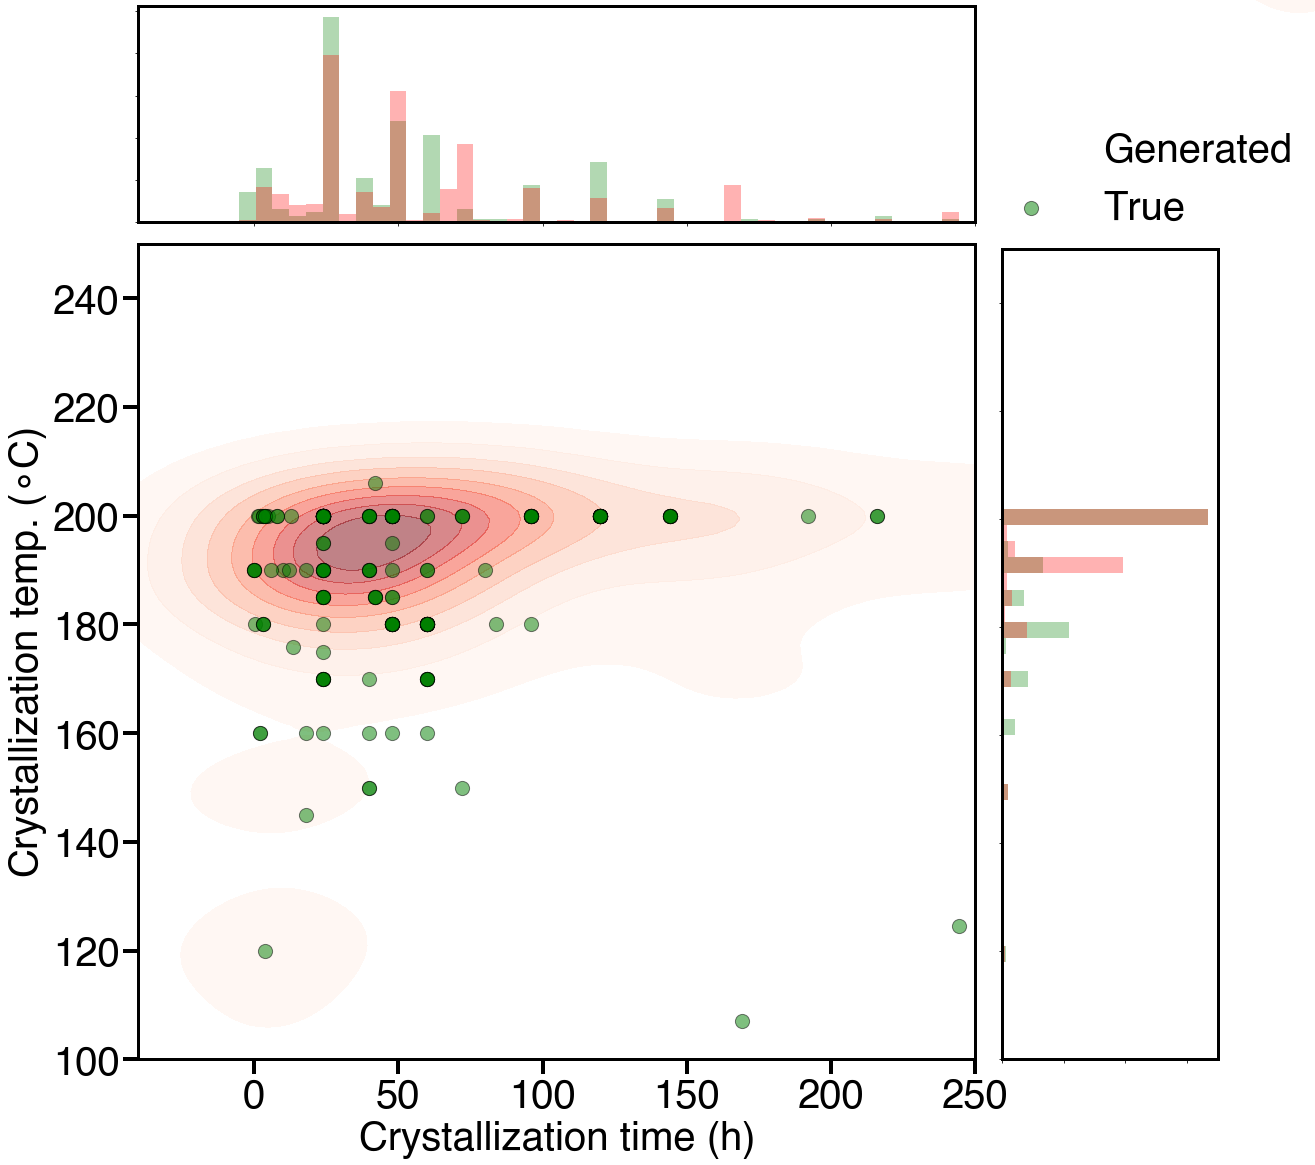

In [8]:
def compare_side_by_side_2d(x, y, syn_pred_list, syn_pred_scaled_list, syn_true, syn_true_scaled, dataset, zeo, osda=None, labels=None, print_metrics=True, pca=False, xlims={}, colors=None, save_path=None):
    
    if osda == None: # Zeolite-aggregated
        print(zeo)

        sys_syn_true = syn_true[syn_true['zeo'] == zeo]
        sys_syn_true_scaled = syn_true_scaled[syn_true_scaled['zeo'] == zeo]
        sys_syn_pred_list = [x[x['zeo'] == zeo] for x in syn_pred_list]
        sys_syn_pred_scaled_list = [x[x['zeo'] == zeo] for x in syn_pred_scaled_list]
    
    else:
        print(zeo, osda)
        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        sys_syn_true_scaled = syn_true_scaled[(syn_true_scaled['zeo'] == zeo) & (syn_true_scaled['osda'] == osda)]
        sys_syn_pred_list = [x[(x['zeo'] == zeo) & (x['osda'] == osda)] for x in syn_pred_list]
        sys_syn_pred_scaled_list = [x[(x['zeo'] == zeo) & (x['osda'] == osda)] for x in syn_pred_scaled_list]


    # KDE version
    bins = 50
    alpha = 0.5
    label_size = 40
    tick_label_size = 40
    title_size = 60
    tick_length = 15
    tick_width = 4 
    xlim = [650, 1350]
    ylim  = [2.6, 6]
    matplotlib.rcParams['axes.linewidth'] = 3

    ### 
    left, width = 0.125, 0.775
    bottom, height = 0.125, 0.75
    spacing = 0.025
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    #define figure
    fig, ax = plt.subplots(figsize=(15, 15))
    fig.set_figheight(15) # figure height
    fig.set_figwidth(15) # figure width

    # sns.kdeplot(data=sys_syn_pred_list[0], x=x, y=y, fill = True, cmap='Blues', alpha=alpha, label='AMD')
    sns.kdeplot(data=sys_syn_pred_list[-1], x=x, y=y, fill = True, cmap='Reds', alpha=alpha, label='Generated', bw_adjust=2)
    plt.scatter(sys_syn_true[x], sys_syn_true[y], alpha=0.5, linewidth=1, edgecolor='black', s=200, color='green', label='True', marker='o')
    plt.xlabel('Crystallization time (h)', size = label_size)
    plt.ylabel('Crystallization temp. ($\circ$C)', size = label_size)
    plt.legend(loc=[0.1,0.1], fontsize = label_size)
    ax.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'out')
    ax.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'out')
    plt.xticks(fontsize = tick_label_size)
    plt.yticks(fontsize = tick_label_size)
    plt.xlim(xlims[x]['min'], xlims[x]['max'])
    plt.ylim(xlims[y]['min'], xlims[y]['max'])
    

    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)

    # no labels from histogram
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False)

    ax_histx.hist(sys_syn_true[x], color = 'green', alpha = 0.3, bins = bins, range=(xlims[x]['min'], xlims[x]['max']), density=True)
    ax_histy.hist(sys_syn_true[y], color = 'green', alpha = 0.3, bins = bins, orientation='horizontal', range=(xlims[y]['min'], xlims[y]['max']), density=True)
    ax_histx.hist(sys_syn_pred_list[-1][x], color = 'red', alpha = 0.3, bins = bins, range=(xlims[x]['min'], xlims[x]['max']), density=True)
    ax_histy.hist(sys_syn_pred_list[-1][y], color = 'red', alpha = 0.3, bins = bins, orientation='horizontal', range=(xlims[y]['min'], xlims[y]['max']), density=True)

    if save_path != None:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')

compare_side_by_side_2d('cryst_time', 'cryst_temp', syn_pred_list, syn_pred_scaled_list, syn_true, syn_true_scaled, dataset, zeo='AEL', osda='CCCNCCC', labels=[x['n'] for x in model2specs.values()]+['True'], colors=[x['c'] for x in model2specs.values()]+['green'],
                                                                xlims={
                                                                     'cryst_time': {'min': -40., 'max': 250},
                                                                     'cryst_temp': {'min': 100, 'max': 250}, 
                                                                     }, save_path='figs/2d_dist.pdf'
                                                                     )